In [21]:
import polars as pl
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(-1)

import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('../')

from exp.features import Features
from exp.models.cat import CatBoostModel
from exp.models.lgbm import LGBMModel
from exp.models.rf import RandomForestModel
from exp.models.rgf import RGFModel
from exp.models.xgb import XGBModel

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

In [22]:
train = pl.read_csv("../input/train.csv")
test = pl.read_csv("../input/test.csv")

In [23]:
from exp.features import FeatureSelecter


features = Features(train, test)
train, test = features.create_features()

selecter = FeatureSelecter(train, test)

predictions = pl.concat([train["price"].to_frame(), pl.DataFrame([None] * test.height, schema={"price": pl.Int64})])

In [24]:
selecter.get_dataframe("lgbm")[0].head()

year,cylinders,odometer,price,odometer_f,age,odometer/age,odometer/cylinders,manufacturer_odometer_mean,manufacturer_odometer_std,manufacturer_odometer_max,manufacturer_odometer_min,manufacturer_odometer_diff,lat,lng,manufacturer_rank,condition_rank,fuel_rank,title_status_rank,transmission_rank,drive_rank,size_rank,type_rank,paint_color_rank,state_rank,manufacturer_count,condition_count,fuel_count,title_status_count,transmission_count,drive_count,size_count,type_count,paint_color_count,state_count,condition_l,size_l,manufacturer_mean,fuel_mean,title_status_mean,transmission_mean,drive_mean,type_mean,paint_color_mean,state_mean,type_year_mean,type_odo_mean,manufacturer_year_mean,manufacturer_odo_mean,manufacturer_acura,manufacturer_alfa_romeo,manufacturer_aston_martin,manufacturer_audi,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land_rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes_benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,fuel_diesel,fuel_electric,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_other,drive_4wd,drive_fwd,type_SUV,type_bus,type_coupe,type_hatchback,type_mini-van,type_nan,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_null,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
i64,i8,i64,i64,f64,i64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
1949,6,115148,27587,115148.0,74,1556.054054,19191.333333,99532.887011,54592.395342,1484310,85,1484225,36.162277,-86.774298,35.0,6.0,5.0,6.0,2.0,1.0,3.0,6.0,3.0,38.0,3044,15219,24785,22821,6156,4834,9411,418,144,689,3,2,13968.291393,12270.566996,13298.318128,12058.838856,15846.747621,13664.002392,11200.854167,15837.718433,2000.011962,102805.990385,2007.308476,99532.887011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013,8,172038,4724,172038.0,10,17203.8,21504.75,150274.987542,63883.018881,386817,877,385940,40.79445,-77.861639,34.0,3.0,5.0,6.0,3.0,1.0,4.0,14.0,11.0,47.0,1784,2404,24785,22821,20497,4834,14636,9259,4300,1107,0,3,9199.164238,12270.566996,13298.318128,13944.440064,15846.747621,9939.633654,11324.39814,13696.32159,2009.920294,115614.553873,2008.

In [25]:
test.head()

id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,odometer_f,age,odometer/age,odometer/cylinders,manufacturer_odometer_mean,manufacturer_odometer_std,manufacturer_odometer_max,manufacturer_odometer_min,manufacturer_odometer_diff,lat,lng,manufacturer_rank,condition_rank,fuel_rank,title_status_rank,transmission_rank,drive_rank,size_rank,type_rank,paint_color_rank,state_rank,manufacturer_count,condition_count,fuel_count,title_status_count,transmission_count,drive_count,size_count,type_count,paint_color_count,state_count,condition_l,size_l,manufacturer_mean,fuel_mean,title_status_mean,transmission_mean,drive_mean,type_mean,paint_color_mean,state_mean,type_year_mean,type_odo_mean,manufacturer_year_mean,manufacturer_odo_mean,manufacturer_acura,manufacturer_alfa_romeo,manufacturer_aston_martin,manufacturer_audi,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land_rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes_benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,fuel_diesel,fuel_electric,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_other,drive_4wd,drive_fwd,type_SUV,type_bus,type_coupe,type_hatchback,type_mini-van,type_nan,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_null,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
i64,cat,i64,cat,cat,i8,cat,i64,cat,cat,cat,cat,cat,cat,cat,f64,i64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
27532,"""western slope""",2015,"""chevrolet""","""excellent""",4,"""gas""",92553,"""clean""","""automatic""","""fwd""","""full-size""","""SUV""","""red""","""co""",92553.0,8,11569.125,23138.25,106742.432289,73304.863787,2946000,120,2945880,39.0,-108.0,36.0,6.0,5.0,6.0,3.0,3.0,4.0,13.0,7.0,43.0,3807,15219,24785,22821,20497,14602,14636,7311,1419,804,3,3,14994.540583,12270.566996,13298.318128,13944.440064,9810.263663,13821.113801,11811.757576,12165.701493,2009.394611,123409.313027,2006.456265,106742.432289,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27533,"""roseburg""",2013,"""nissan""","""like new""",4,"""gas""",134385,""

In [26]:
predictions = pl.concat([train["price"].to_frame(), pl.DataFrame([None] * test.height, schema={"price": pl.Int64})])

In [27]:
lgbm = LGBMModel(*selecter.get_dataframe("lgbm"))
#lgbm.objective(20)
lgbm.best_params = {'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 91, 'subsample': 0.5578230915019112, 'colsample_bytree': 0.5933052522026404, 'reg_alpha': 2.4725566626090776e-05, 'reg_lambda': 1.0114136512530978e-08, 'feature_fraction': 0.7523757350552451, 'bagging_fraction': 0.9199865329355417, 'bagging_freq': 5}
lgbm_predictions = lgbm.predict()
predictions = pl.concat([predictions, lgbm_predictions], how="horizontal")

Fold_lgbm 0: 0.43799712143182123
Fold_lgbm 1: 0.44280409397358655
Fold_lgbm 2: 0.4436114584232364
Fold_lgbm 3: 0.44357183995305854
Fold_lgbm 4: 0.4444853910975215


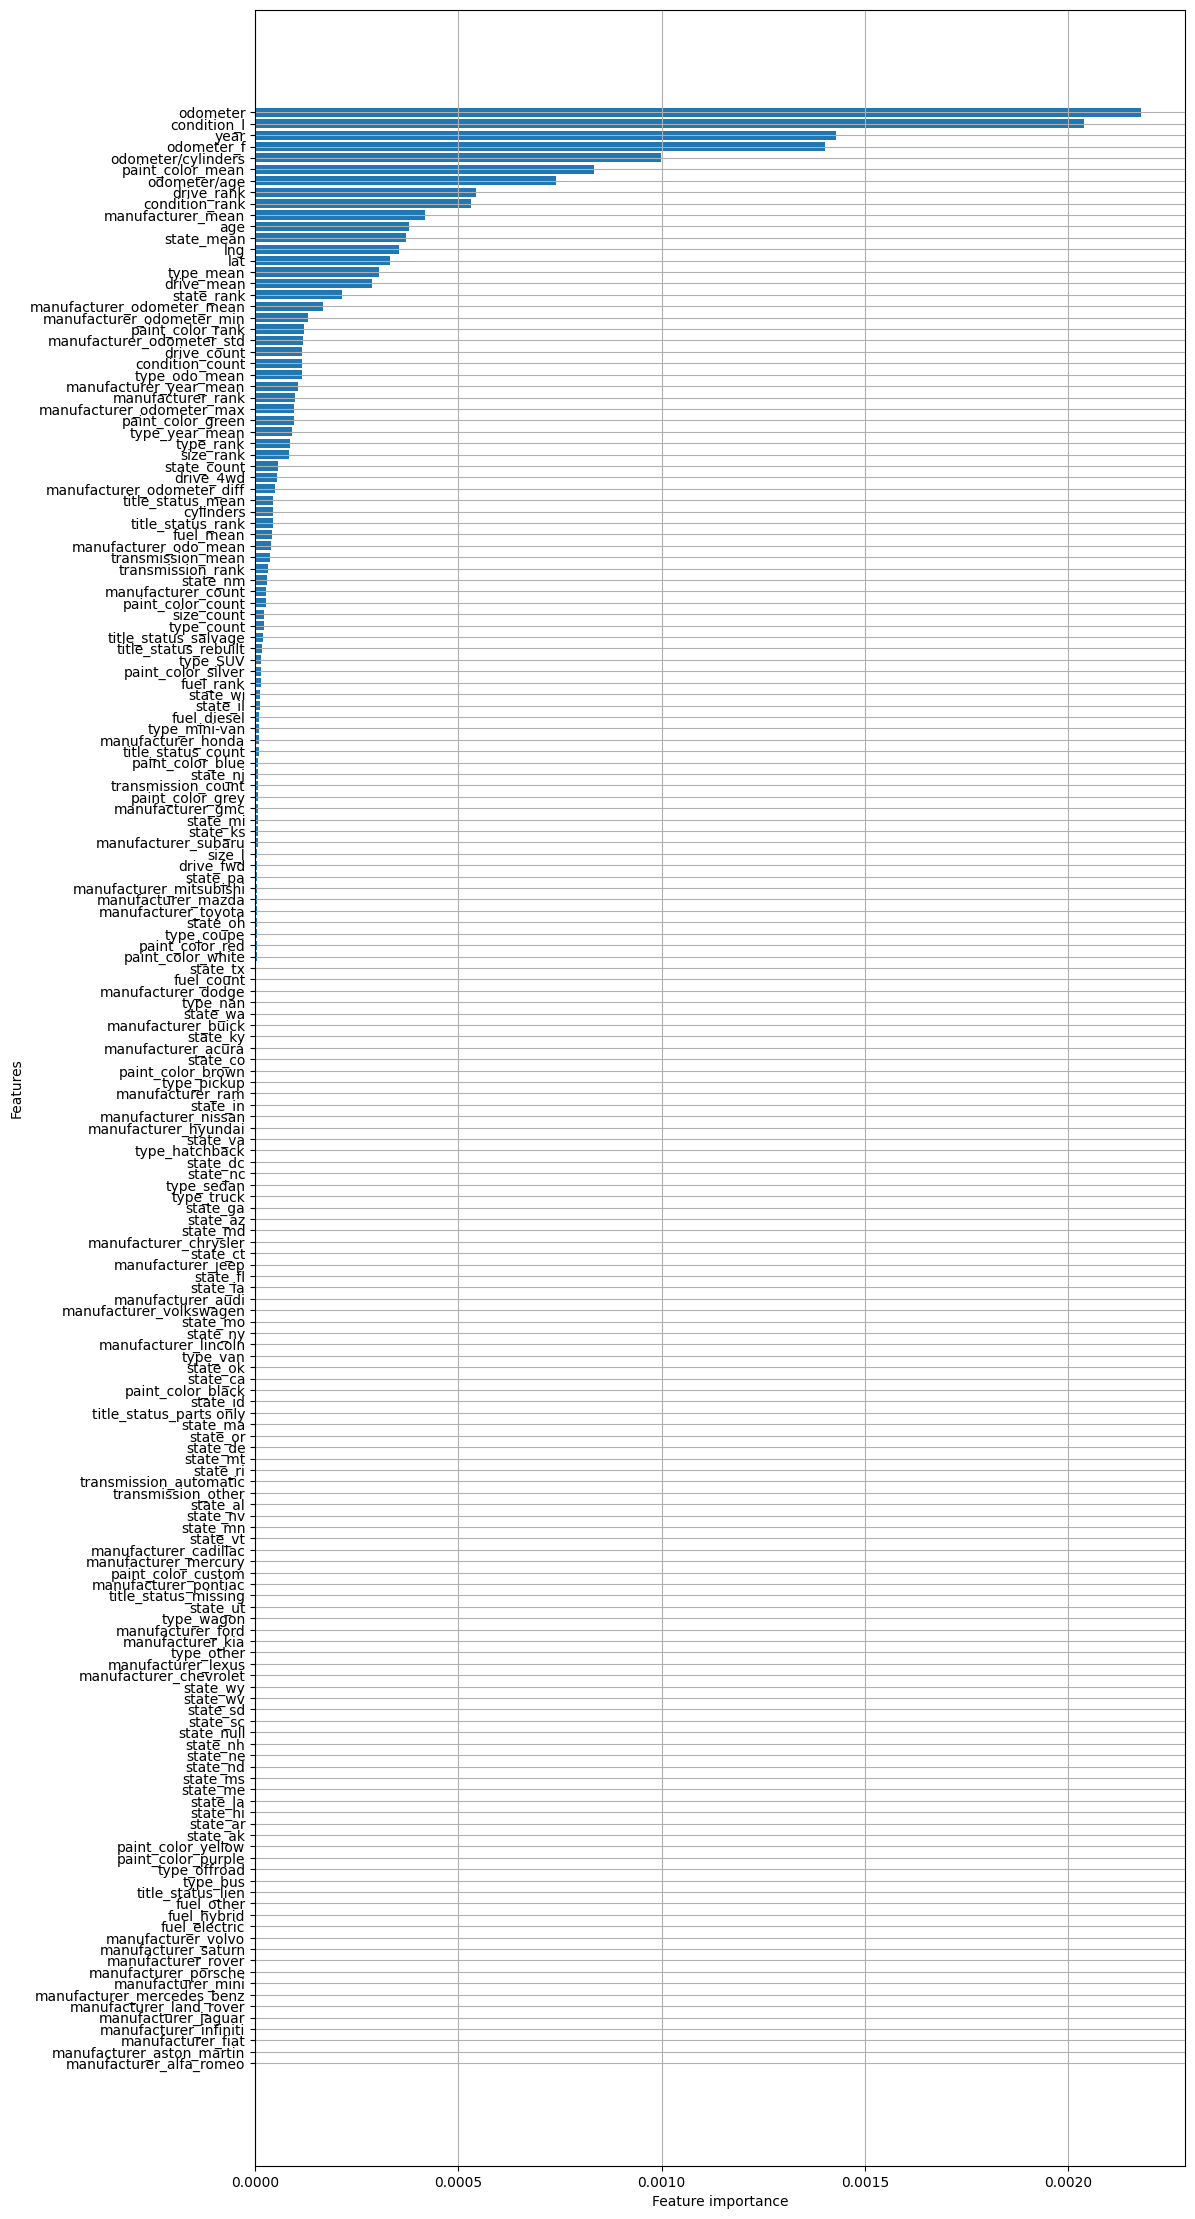

In [28]:
importance = lgbm.feature_importance()
importance = importance.sort(by='lgbm_importance_mean')
#グラフ表示
plt.figure(figsize=(12, 28))
plt.barh(importance['feature'], importance['lgbm_importance_mean'])
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.grid()
plt.show()

In [29]:
#xgb = XGBModel(train, test)
#xgb.objective(20)
#xgb.best_params = {'n_estimators': 767, 'max_depth': 8, 'lambda': 1.2306916748991704e-06, 'alpha': 0.018078104089246788, 'colsample_bytree': 0.42319770953022684, 'subsample': 0.2810517802368746, 'min_child_weight': 218, 'gamma': 6.031109467976734e-08, 'eta': 0.018889170085640027}
#xgb_predictions = xgb.predict()
#predictions = pl.concat([predictions, xgb_predictions], how="horizontal")

In [30]:
#rf = RandomForestModel(df)
##rf.objective(5)
#rf.best_params = {'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 0.6306125661502896, 'max_leaf_nodes': 18, 'n_estimators': 8762, 'bootstrap': True}
#rf_predictions = rf.predict()
#predictions = pd.concat([predictions, rf_predictions], axis=1)

In [31]:
#rgf = RGFModel(df)
##rgf.objective(5)
#rgf.best_params = {'max_leaf': 8072, 'algorithm': 'RGF_Opt', 'test_interval': 142, 'min_samples_leaf': 11, 'reg_depth': 9, 'l2': 0.0002082492344277923, 'sl2': 4.2919223241162815e-07, 'normalize': False}
#rgf_predictions = rgf.predict()
#predictions = pd.concat([predictions, rgf_predictions], axis=1)

In [32]:
#cat = CatBoostModel(df)
##cat.objective(5)
#cat.best_params = {"depth": 6}
#cat_predictions = cat.predict()
#predictions = pd.concat([predictions, cat_predictions], axis=1)

In [33]:
predictions.head()

price,lgbm_pred_0,lgbm_pred_1,lgbm_pred_2,lgbm_pred_3,lgbm_pred_4
i64,f64,f64,f64,f64,f64
27587,6677.515314,7195.556183,7092.651218,6644.065571,7438.826902
4724,3522.709574,3489.738315,3473.293352,3710.1634,3330.047203
10931,3579.870267,3347.294895,3158.0355,3557.200893,3453.080566
16553,8317.394054,8561.332411,8765.703809,8383.161234,8822.987021
5158,4156.747842,4482.840255,4169.595867,4410.160303,4343.746297


In [34]:
#model = Ridge(random_state=0)
#train = predictions[predictions["price"].notnull()]
#test = predictions[predictions["price"].isnull()]
#X_train = train.drop(["price"], axis=1)
#y_train = train["price"]
#X_test = test.drop(["price"], axis=1)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

In [35]:
y_pred = lgbm_predictions.mean(axis=1)[train.height:].to_list()

In [36]:
#sub = pl.read_csv(os.path.join(os.path.dirname(__file__), "../input/submit_sample.csv"), has_header=False, new_columns=["id", "price"])
#sub = sub.with_columns(pl.Series("", y_pred).alias("price"))
#sub.write_csv(os.path.join(os.path.dirname(__file__), "../output/submission_te0810_3.csv"), has_header=False)